In [ ]:
!uname -a
!g++ --version
!nvidia-smi
!nvcc --version || echo "No nvcc yet (enable GPU runtime later)"

Linux cc15cb9b8a44 6.6.113+ #1 SMP Mon Feb  2 12:27:57 UTC 2026 x86_64 x86_64 x86_64 GNU/Linux
g++ (Ubuntu 11.4.0-1ubuntu1~22.04.2) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Fri Feb 27 18:03:01 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+=======

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

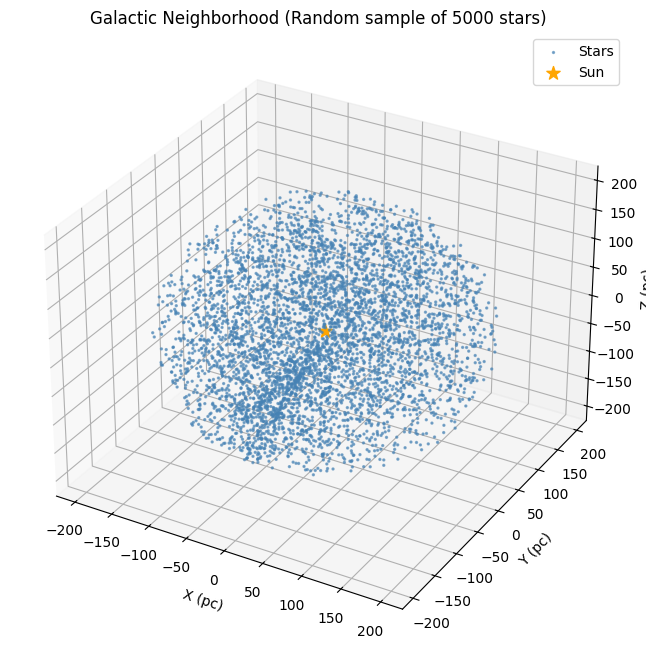

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
GAIA_CARTESIAN_FILENAME = 'GAIA_DR3_Cartesian_Heliocentric.csv'
gaia_cartesian_df = pd.read_csv("/content/drive/MyDrive/PDPProject/DATASET/" + GAIA_CARTESIAN_FILENAME)

def plot_gaia_3d(df, title, output_file, point_size=2, alpha=0.6):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot stars
    ax.scatter(
        df['x'], df['y'], df['z'],
        color='steelblue',
        s=point_size,
        alpha=alpha,
        label='Stars'
    )

    # Sun
    ax.scatter([0], [0], [0],
               color='orange', s=100, marker='*', label='Sun')

    ax.set_xlabel('X (pc)')
    ax.set_ylabel('Y (pc)')
    ax.set_zlabel('Z (pc)')
    ax.set_title(title)

    ax.legend()

def plot_random_gaia_neighborhood(df, subset_size):
    df_sample = (
        df.sample(n=subset_size, random_state=42)
        if len(df) > subset_size else df
    )

    title = f'Galactic Neighborhood (Random sample of {len(df_sample)} stars)'
    output_file = f'GAIA_random_neighborhood_{subset_size}.png'

    plot_gaia_3d(df_sample, title, output_file, point_size=2, alpha=0.6)

plot_random_gaia_neighborhood(gaia_cartesian_df, 5000)

## Sequential DBSCAN

In [37]:
%%writefile dbscan.cu
/**
 * @brief Sequential DBSCAN implementation for 3D star clustering.
 */

#include <iostream>
#include <vector>
#include <fstream>
#include <sstream>
#include <string>
#include <queue>

#include "/content/drive/MyDrive/PDPProject/UTILS/Output_Utils.h"


#include <iomanip>
#include <ctime>

using namespace std;

/**
 * @brief Represents a star with 3D coordinates and clustering metadata.
 */
struct Star {
    double x;
    double y;
    double z;
    int label = -1;       // -1 means unclassified, 0 means noise, >0 means cluster ID
    bool visited = false; // True if the point has been processed
};

/**
 * @brief Computes the squared Euclidean distance between two stars.
 * @param star1 First star
 * @param star2 Second star
 * @return Squared distance
 */
double squaredDistance(const Star& star1, const Star& star2) {
    double dx = star1.x - star2.x;
    double dy = star1.y - star2.y;
    double dz = star1.z - star2.z;
    return dx*dx + dy*dy + dz*dz;
}

/**
 * @brief Finds all stars within a given radius (eps) from a specific star.
 * @param stars Reference to the full dataset of stars
 * @param star The center star for the range query
 * @param eps The neighborhood radius
 * @return Vector of pointers to neighboring stars
 */
vector<Star*> rangeQuery(vector<Star>& stars, const Star& star, double eps) {
    vector<Star*> neighbors;
    for (Star& s : stars) {
        // Compare with eps*eps to avoid expensive sqrt computation
        if (squaredDistance(star, s) <= eps*eps) {
            neighbors.push_back(&s);
        }
    }
    return neighbors;
}

/**
 * @brief Expands the cluster starting from a specific core point.
 * @param stars The full dataset of stars
 * @param start The initial core point
 * @param neighbors Neighbors of the initial point
 * @param cluster_id The ID to assign to stars in this cluster
 * @param eps The neighborhood radius
 * @param minPts Minimum points required to form a dense region
 */
void expandCluster(
    vector<Star>& stars,
    Star& start,
    vector<Star*> neighbors,
    int cluster_id,
    double eps,
    int minPts
) {
    start.label = cluster_id;

    std::queue<Star*> q;

    // Insert all initial neighbors into the queue for processing
    for (Star* n : neighbors)
        q.push(n);

    while (!q.empty()) {

        Star* current = q.front();
        q.pop();

        if (!current->visited) {

            current->visited = true;

            auto currentNeighbors = rangeQuery(stars, *current, eps);

            // If the current point is also a core point, add its neighbors to the queue
            if (currentNeighbors.size() >= minPts) {

                // ALWAYS add all newly found neighbors
                for (Star* nb : currentNeighbors)
                    q.push(nb);
            }
        }

        // If the point is unclassified (-1) or marked as noise (0), assign it to the current cluster
        if (current->label <= 0) {
            current->label = cluster_id;
        }
    }
}

/**
 * @brief Main DBSCAN algorithm execution.
 * @param stars The full dataset of stars to cluster
 * @param eps Epsilon, the neighborhood radius for DBSCAN
 * @param minPts Minimum points required to form a core point (includes the point itself)
 */
void dbscan(vector<Star>& stars, double eps, int minPts) {
    int clusters = 0;

    for (Star& star : stars) {
        if (star.visited) continue;

        star.visited = true;

        // Find neighbors to check if it's a core point
        vector<Star*> neighbors = rangeQuery(stars, star, eps);
        if (neighbors.size() < minPts) {
            star.label = 0; // Mark as noise
            continue;
        }

        clusters++; // Found a new cluster
        expandCluster(stars, star, neighbors, clusters, eps, minPts);
    }
}

// ============ CSV Reading ============

/**
 * @brief Loads a dataset of stars from a CSV file.
 * @param filename Path to the CSV file
 * @return Vector containing the loaded stars
 */
vector<Star> loadCSV(const string& filename) {
    vector<Star> stars;
    ifstream file(filename);
    if (!file.is_open()) {
        cerr << "Error: unable to open " << filename << endl;
        return stars;
    }
    string line;
    getline(file, line); // skip header row

    while (getline(file, line)) {
        stringstream ss(line);
        string token;

        getline(ss, token, ','); // Read source_id -> ignore it

        Star star;
        getline(ss, token, ','); star.x = stod(token);
        getline(ss, token, ','); star.y = stod(token);
        getline(ss, token, ','); star.z = stod(token);
        stars.push_back(star);
    }
    return stars;
}

/**
 * @brief Main entry point. Loads the dataset, executes DBSCAN, and measures runtime.
 */
int main() {
    vector<std::string> datasets = {
         "GAIA_nearest_1000.csv",
         "GAIA_nearest_10000.csv",
         "GAIA_nearest_50000.csv",
        // "GAIA_nearest_100000.csv",
        // "GAIA_nearest_200000.csv"
    };

    for (string dataset : datasets) {
        // Load dataset
        string GAIA_CARTESIAN_FILENAME = dataset;
        vector<Star> stars = loadCSV("/content/drive/MyDrive/PDPProject/DATASET/" + GAIA_CARTESIAN_FILENAME);
        cout << "Stars loaded: " << stars.size() << endl;

        if (stars.empty()) return 1;

        // Execute DBSCAN (eps and minPts parameters should be calibrated)
        double eps = 2;
        int minPts = 7;
        cout << "Executing DBSCAN with eps=" << eps << ", minPts=" << minPts << " ..." << endl;

        // Timing Setup
        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);
        cudaEventRecord(start);

        dbscan(stars, eps, minPts);

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float ms = 0;
        cudaEventElapsedTime(&ms, start, stop);
        cout << "Execution time: " << ms << " ms" << endl;

        // Count and print results
        int noise = 0, maxCluster = 0;
        for (const auto& s : stars) {
            if (s.label == 0) noise++;
            if (s.label > maxCluster) maxCluster = s.label;
        }
        cout << "Clusters found: " << maxCluster << endl;
        cout << "Noise points: " << noise << " / " << stars.size() << endl;



        logBenchmarkResult("seq_dbscan", stars.size(), maxCluster, 1, 1, 1, ms / 1000.0);

        printf("----------------------------------------------------------------\n");

    }

    return 0;
}

Overwriting dbscan.cu


In [38]:
!nvcc -O3 dbscan.cu -o dbscan

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [39]:
!./dbscan

Stars loaded: 1000
Executing DBSCAN with eps=2, minPts=7 ...
Execution time: 2.02707 ms
Clusters found: 19
Noise points: 792 / 1000
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/seq_dbscan.csv
----------------------------------------------------------------
Stars loaded: 10000
Executing DBSCAN with eps=2, minPts=7 ...
Execution time: 171.633 ms
Clusters found: 219
Noise points: 6963 / 10000
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/seq_dbscan.csv
----------------------------------------------------------------
Stars loaded: 50000
Executing DBSCAN with eps=2, minPts=7 ...
Execution time: 4701.03 ms
Clusters found: 973
Noise points: 29765 / 50000
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/seq_dbscan.csv
----------------------------------------------------------------


## Parallel DBSCAN

In [34]:
%%writefile g_dbscan.cu
// dbscan2.cu — G-DBSCAN (improved version)
// Combines the modularity of dbscan.cu with the efficiency of dbscan1.cu.
// Key improvements:
//   - Thrust throughout (RAII, no manual cudaFree)
//   - Minimal D->H transfer for total_edges (only 2 integers)
//   - Graph struct for modularity
//   - CHECK_CUDA on all critical points
//   - Correct frontier reset (pre-swap) with clear of output buffer only
//   - Explicit synchronization with error checking

#include <cuda_runtime.h>
#include <device_launch_parameters.h>
#include <iostream>
#include <vector>
#include <fstream>
#include <sstream>
#include <iomanip>
#include <ctime>

#include <thrust/device_vector.h>
#include <thrust/execution_policy.h>
#include <thrust/fill.h>
#include <thrust/scan.h>

#include "/content/drive/MyDrive/PDPProject/UTILS/Output_Utils.h"

#include "/content/drive/MyDrive/PDPProject/UTILS/common.cuh"

// ---------------------------------------------------------------------------
// DATA STRUCTURES
// ---------------------------------------------------------------------------

// Graph in CSR format: all vectors are device_vectors (automatic RAII)
struct Graph {
  thrust::device_vector<int> row_ptr;     // row pointers: row_ptr[i]..row_ptr[i+1] spans neighbors of point i
  thrust::device_vector<int> col_indices; // column indices: neighbor point indices
};

// ---------------------------------------------------------------------------
// KERNELS
// ---------------------------------------------------------------------------

// Counts the neighbors of each point (degrees), used to build row_ptr.
// Uses shared memory tiling: each block loads a tile of points into shared
// memory so that all threads in the block can reuse those reads together.
__global__ __launch_bounds__(BLOCK_SIZE) void count_neighbors_kernel(
    const Point3D *__restrict__ points, int *__restrict__ degrees,
    int num_points, float eps) {
  int idx = blockDim.x * blockIdx.x + threadIdx.x;
  __shared__ Point3D sh_points[BLOCK_SIZE]; // shared memory tile for current block

  Point3D my_point;
  if (idx < num_points)
    my_point = points[idx];

  int count = 0;
  int num_tiles = (num_points + BLOCK_SIZE - 1) / BLOCK_SIZE;

  // Iterate over all tiles of points to count neighbors within eps
  for (int t = 0; t < num_tiles; ++t) {
    // Cooperatively load the current tile into shared memory
    int tile_idx = t * BLOCK_SIZE + threadIdx.x;
    if (tile_idx < num_points)
      sh_points[threadIdx.x] = points[tile_idx];
    __syncthreads(); // ensure tile is fully loaded before any thread reads it

    if (idx < num_points) {
      int num_in_tile = min(BLOCK_SIZE, num_points - t * BLOCK_SIZE);
      for (int j = 0; j < num_in_tile; ++j) {
        if (euclidean_distance(my_point, sh_points[j]) <= eps)
          count++;
      }
    }
    __syncthreads(); // ensure all threads are done before next tile is loaded
  }

  if (idx < num_points)
    degrees[idx] = count;
}

// KERNEL 1: Builds the adjacency list (col_indices) in CSR format.
// Each thread writes the neighbor indices of its assigned point starting at
// row_ptr[idx], which was pre-computed by prefix sum over degrees.
__global__ __launch_bounds__(BLOCK_SIZE) void construct_adjacency_list(
    const Point3D *__restrict__ points, const int *__restrict__ row_ptr,
    int *__restrict__ col_indices, int num_points, float eps) {
  int idx = blockDim.x * blockIdx.x + threadIdx.x;
  __shared__ Point3D sh_points[BLOCK_SIZE]; // shared memory tile for current block

  Point3D my_point;
  int start_offset = 0, count = 0;

  if (idx < num_points) {
    my_point = points[idx];
    start_offset = row_ptr[idx]; // starting write position in col_indices
  }

  int num_tiles = (num_points + BLOCK_SIZE - 1) / BLOCK_SIZE;

  // Iterate over all tiles; write neighbor indices into col_indices
  for (int t = 0; t < num_tiles; ++t) {
    int tile_idx = t * BLOCK_SIZE + threadIdx.x;
    if (tile_idx < num_points)
      sh_points[threadIdx.x] = points[tile_idx];
    __syncthreads();

    if (idx < num_points) {
      int num_in_tile = min(BLOCK_SIZE, num_points - t * BLOCK_SIZE);
      for (int j = 0; j < num_in_tile; ++j) {
        if (euclidean_distance(my_point, sh_points[j]) <= eps)
          col_indices[start_offset + count++] = t * BLOCK_SIZE + j;
      }
    }
    __syncthreads();
  }
}

// KERNEL 2: Identifies core points (degree >= min_pts).
// A point is a core point if the number of neighbors (including itself)
// stored in the CSR row is at least min_pts. Result written to node_type[].
__global__ __launch_bounds__(BLOCK_SIZE) void identify_core_points_kernel(
    const int *__restrict__ row_ptr, int *__restrict__ node_type,
    int num_points, int min_pts) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  if (idx < num_points)
    node_type[idx] = (row_ptr[idx + 1] - row_ptr[idx] >= min_pts) ? 1 : 0;
}

// KERNEL 3: BFS propagation — expands the current frontier.
// Each thread in the current frontier assigns the cluster ID to unvisited
// neighbors. Only core-point neighbors are added to the next frontier,
// preventing border points from further expanding the cluster.
__global__ __launch_bounds__(BLOCK_SIZE) void bfs_propagate_kernel(
    const int *__restrict__ row_ptr, const int *__restrict__ col_indices,
    int *__restrict__ cluster_ids, bool *__restrict__ current_frontier,
    bool *__restrict__ next_frontier, const int *__restrict__ node_type,
    int num_points, int current_cluster_id, bool *__restrict__ d_continue) {

  int tid = blockIdx.x * blockDim.x + threadIdx.x;
  if (tid >= num_points || !current_frontier[tid])
    return;

  // Visit all neighbors of this frontier node
  for (int e = row_ptr[tid]; e < row_ptr[tid + 1]; ++e) {
    int neighbor = col_indices[e];
    if (cluster_ids[neighbor] == 0) { // unvisited
      cluster_ids[neighbor] = current_cluster_id;
      // Only core points expand the frontier further
      if (node_type[neighbor] == 1) {
        next_frontier[neighbor] = true;
        *d_continue = true; // signal that BFS should continue
      }
    }
  }
  current_frontier[tid] = false; // remove current node from frontier
}

// ---------------------------------------------------------------------------
// MAIN
// ---------------------------------------------------------------------------

int main() {
  std::vector<std::string> datasets = {
         "GAIA_nearest_1000.csv",
         "GAIA_nearest_10000.csv",
         "GAIA_nearest_50000.csv",
         "GAIA_nearest_100000.csv",
        // "GAIA_nearest_200000.csv",

        // "GAIA_nearest_1000000.csv",
        // "GAIA_DR3_Cartesian_Heliocentric.csv"
  };

  for (std::string dataset : datasets) {

    const std::string filename =
        "/content/drive/MyDrive/PDPProject/DATASET/" + dataset;
    const float epsilon = 2.0f;  // neighborhood radius for DBSCAN
    const int min_pts = 7;       // minimum neighbors to be a core point

    printf("G-DBSCAN v2 (improved)\nDataset: %s\nParams: Eps=%.2f, MinPts=%d\n",
          filename.c_str(), epsilon, min_pts);

    // 1. Load dataset from CSV into host memory
    std::vector<Point3D> h_points_vec;
    int num_points = load_dataset(filename, h_points_vec);
    if (num_points == 0) {
      fprintf(stderr, "Error: empty or missing dataset.\n");
      return 1;
    }

    // 2. Transfer points to device using Thrust (RAII, no manual cudaMalloc)
    thrust::device_vector<Point3D> d_points = h_points_vec;

    // 3. Auxiliary device structures (all managed by Thrust)
    thrust::device_vector<int> d_node_type(num_points);          // 1 = core, 0 = border/noise
    thrust::device_vector<int> d_cluster_ids(num_points, 0);     // 0 = unassigned
    thrust::device_vector<bool> d_frontier_a(num_points, false); // ping buffer for BFS
    thrust::device_vector<bool> d_frontier_b(num_points, false); // pong buffer for BFS
    thrust::device_vector<bool> d_continue_flag(1, false);       // BFS continuation flag

    // Raw pointers used only for kernel calls (Thrust manages lifetime)
    const Point3D *rp_points = thrust::raw_pointer_cast(d_points.data());
    int *rp_node_type        = thrust::raw_pointer_cast(d_node_type.data());
    int *rp_cluster_ids      = thrust::raw_pointer_cast(d_cluster_ids.data());
    bool *rp_frontier_a      = thrust::raw_pointer_cast(d_frontier_a.data());
    bool *rp_frontier_b      = thrust::raw_pointer_cast(d_frontier_b.data());
    bool *rp_continue        = thrust::raw_pointer_cast(d_continue_flag.data());

    // --- TIMING: measure total GPU execution time with CUDA events ---
    cudaEvent_t ev_start, ev_stop;
    CHECK_CUDA(cudaEventCreate(&ev_start));
    CHECK_CUDA(cudaEventCreate(&ev_stop));
    CHECK_CUDA(cudaEventRecord(ev_start));

    const int block = BLOCK_SIZE;
    const int grid  = (num_points + block - 1) / block;

    // -------------------------------------------------------------------------
    // PHASE 1: Build CSR graph
    // -------------------------------------------------------------------------

    // 1a: Count neighbors (degrees) for each point
    thrust::device_vector<int> d_degrees(num_points);
    count_neighbors_kernel<<<grid, block>>>(
        rp_points, thrust::raw_pointer_cast(d_degrees.data()),
        num_points, epsilon);
    CHECK_CUDA(cudaDeviceSynchronize());

    // 1b: Exclusive prefix sum over degrees to produce row_ptr.
    // Minimal host transfer: only 2 scalar values are read from the device
    // to compute total_edges, avoiding a full copy.
    Graph g;
    g.row_ptr.resize(num_points + 1);
    thrust::exclusive_scan(d_degrees.begin(), d_degrees.end(), g.row_ptr.begin());
    int total_edges = g.row_ptr[num_points - 1] + d_degrees[num_points - 1];
    g.row_ptr[num_points] = total_edges; // sentinel: total number of edges

    printf("Phase 1b: Prefix sum done. Total edges: %d\n", total_edges);

    // 1c: Build col_indices using the computed row_ptr offsets
    g.col_indices.resize(total_edges);
    construct_adjacency_list<<<grid, block>>>(
        rp_points,
        thrust::raw_pointer_cast(g.row_ptr.data()),
        thrust::raw_pointer_cast(g.col_indices.data()),
        num_points, epsilon);
    CHECK_CUDA(cudaDeviceSynchronize());

    // Raw pointers to graph arrays (stabilized after final resize)
    const int *rp_row_ptr     = thrust::raw_pointer_cast(g.row_ptr.data());
    const int *rp_col_indices = thrust::raw_pointer_cast(g.col_indices.data());

    // -------------------------------------------------------------------------
    // PHASE 2: Identify core points
    // -------------------------------------------------------------------------
    identify_core_points_kernel<<<grid, block>>>(
        rp_row_ptr, rp_node_type, num_points, min_pts);
    CHECK_CUDA(cudaDeviceSynchronize());

    // -------------------------------------------------------------------------
    // PHASE 3: BFS Clustering
    // -------------------------------------------------------------------------

    // Copy node_type and cluster_ids to host; used for iterating seed selection
    // without launching a kernel for every candidate point
    std::vector<int> h_node_type(num_points);
    std::vector<int> h_cluster_ids(num_points, 0);
    thrust::copy(d_node_type.begin(), d_node_type.end(), h_node_type.begin());

    int current_cluster_id = 1; // cluster IDs start at 1 (0 = unassigned)

    for (int i = 0; i < num_points; ++i) {
      // Skip non-core or already-labeled points
      if (h_node_type[i] != 1 || h_cluster_ids[i] != 0)
        continue;

      // Seed a new cluster from this unvisited core point
      h_cluster_ids[i]  = current_cluster_id;
      d_cluster_ids[i]  = current_cluster_id; // implicit single-element copy to device
      d_frontier_a[i]   = true;               // mark seed as frontier entry point

      bool *ptr_in  = rp_frontier_a;
      bool *ptr_out = rp_frontier_b;

      // Iterative BFS with double buffering (ping-pong between frontier_a and frontier_b)
      while (true) {
        // Reset continuation flag before each BFS step
        d_continue_flag[0] = false;

        // Clear the OUTPUT buffer before writing new frontier nodes into it.
        // This is done before the swap so the kernel writes into a clean buffer.
        thrust::fill(thrust::device, ptr_out, ptr_out + num_points, false);

        bfs_propagate_kernel<<<grid, block>>>(
            rp_row_ptr, rp_col_indices, rp_cluster_ids,
            ptr_in, ptr_out, rp_node_type,
            num_points, current_cluster_id, rp_continue);
        CHECK_CUDA(cudaDeviceSynchronize());

        // Swap ping-pong buffers: old output becomes new input for next step
        std::swap(ptr_in, ptr_out);

        // The buffer that just became the new output (old input) will be cleared
        // at the start of the next iteration, so no extra reset is needed here.

        if (!d_continue_flag[0])
          break; // no new frontier nodes were added; BFS is complete
      }

      // Sync host cluster_ids with the device after finishing this cluster's BFS
      thrust::copy(d_cluster_ids.begin(), d_cluster_ids.end(),
                  h_cluster_ids.begin());
      current_cluster_id++;

      // Reset both frontier buffers before seeding the next cluster.
      // ptr_in may still hold stale data from the last BFS step, so both
      // buffers are cleared to be safe.
      thrust::fill(d_frontier_a.begin(), d_frontier_a.end(), false);
      thrust::fill(d_frontier_b.begin(), d_frontier_b.end(), false);
    }

    // --- TIMING END ---
    CHECK_CUDA(cudaEventRecord(ev_stop));
    CHECK_CUDA(cudaEventSynchronize(ev_stop));
    float ms = 0.f;
    CHECK_CUDA(cudaEventElapsedTime(&ms, ev_start, ev_stop));

    int total_clusters = current_cluster_id - 1;
    printf("Execution Time: %.3f ms\n", ms);
    printf("Total Clusters Found: %d\n", total_clusters);

    // Cleanup CUDA events (all device_vectors are freed automatically by Thrust)
    CHECK_CUDA(cudaEventDestroy(ev_start));
    CHECK_CUDA(cudaEventDestroy(ev_stop));

    logBenchmarkResult("parallel_dbscan", num_points, total_clusters, block, grid, 1, ms / 1000.0);

    printf("----------------------------------------------------------------\n");
  }

  return 0;
}

Overwriting g_dbscan.cu


In [35]:
!nvcc -O3 -arch=sm_75 -std=c++17 g_dbscan.cu -o g_dbscan

In [36]:
!./g_dbscan

G-DBSCAN v2 (improved)
Dataset: /content/drive/MyDrive/PDPProject/DATASET/GAIA_nearest_1000.csv
Params: Eps=2.00, MinPts=7
Read 1000 points from CSV.
Phase 1b: Prefix sum done. Total edges: 3686
Execution Time: 5.253 ms
Total Clusters Found: 19
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/parallel_dbscan.csv
----------------------------------------------------------------
G-DBSCAN v2 (improved)
Dataset: /content/drive/MyDrive/PDPProject/DATASET/GAIA_nearest_10000.csv
Params: Eps=2.00, MinPts=7
Read 10000 points from CSV.
Phase 1b: Prefix sum done. Total edges: 46880
Execution Time: 40.026 ms
Total Clusters Found: 219
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/parallel_dbscan.csv
----------------------------------------------------------------
G-DBSCAN v2 (improved)
Dataset: /content/drive/MyDrive/PDPProject/DATASET/GAIA_nearest_50000.csv
Params: Eps=2.00, MinPts=7
Read 50000 points from CSV.
Phase 1b: Prefix sum done. Total edges: 546944
Exec

## SLINK

In [40]:
%%writefile main_fof.cu
#include "/content/drive/MyDrive/PDPProject/SLINK/SLINK.h"
#include "/content/drive/MyDrive/PDPProject/SLINK/Utils.h"
#include "/content/drive/MyDrive/PDPProject/UTILS/Output_Utils.h"
#include <vector>
#include <iostream>
#include <cmath>

#include <fstream>
#include <sstream>
#include <iomanip>
#include <ctime>

using namespace std;

// Compute the Euclidean distance between two points represented as float vectors.
float euclideanDistance(vector<float> a, vector<float> b) {
    float sum = 0;
    for (int i = 0; i < a.size(); i++) {
        sum += (a[i] - b[i]) * (a[i] - b[i]);
    }
    return sqrt(sum);
}

int main() {
    vector<std::string> datasets = {
         "GAIA_nearest_1000.csv",
         "GAIA_nearest_10000.csv",
         "GAIA_nearest_50000.csv",
        // "GAIA_nearest_100000.csv",
        // "GAIA_nearest_200000.csv"
    };

    for (string dataset : datasets) {
        std::string GAIA_CARTESIAN_FILENAME = dataset;

        std::string filename = "/content/drive/MyDrive/PDPProject/DATASET/" + GAIA_CARTESIAN_FILENAME;

        // 1. Read the CSV file into a 2D vector of floats
        vector<vector<float>> rawData;
        readCsv(rawData, filename, ',');

        // 2. Extract only the x, y, z columns (indices 1, 2, 3).
        //    Start from row 1 to skip the CSV header row.
        vector<vector<float>> data;
        for (int i = 1; i < rawData.size(); i++) {  // i = 1 to skip the header
            vector<float> point = { rawData[i][1], rawData[i][2], rawData[i][3] };
            data.push_back(point);
        }

        cout << "Loaded points: " << data.size() << endl;

        // --- TIMING SETUP ---
        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);
        cudaEventRecord(start);

        // 3. Run the SLINK single-linkage clustering algorithm.
        SLINK slink;
        vector<vector<float>> linkageMatrix;
        slink.clusterize(data, linkageMatrix, euclideanDistance);

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);
        float ms = 0;
        cudaEventElapsedTime(&ms, start, stop);

        // 4. Count the number of clusters for the given distance threshold.
        //    We start assuming each point is its own cluster, then decrement
        //    for every merge that occurred at or below the threshold distance.
        float threshold = 2.0f;  // Distance threshold
        int numClusters = data.size();
        for (int i = 0; i < linkageMatrix.size(); i++) {
            if (linkageMatrix[i][2] <= threshold) {
                numClusters--;
            }
        }

        // --- Output results ---
        printf("Execution Time: %.3f ms\n", ms);
        cout << "Distance threshold: " << threshold << endl;
        cout << "Number of clusters: " << numClusters << endl;

        logBenchmarkResult("slink", data.size(), numClusters, 1, 1, 1, ms / 1000.0);


        // Save linkage matrix to CSV
        string outFilename = "linkage_" + GAIA_CARTESIAN_FILENAME;
        toCsv(linkageMatrix, outFilename);
        cout << "Saved linkage matrix to: " << outFilename << endl;

        printf("----------------------------------------------------------------\n");
    }

    return 0;
}

Overwriting main_fof.cu


In [41]:
!nvcc -O3 main_fof.cu /content/drive/MyDrive/PDPProject/SLINK/SLINK.cpp /content/drive/MyDrive/PDPProject/SLINK/Utils.cpp -o main_fof

nvcc warning : Support for offline compilation for architectures prior to '<compute/sm/lto>_75' will be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
/content/drive/MyDrive/PDPProject/SLINK/SLINK.cpp: In member function ‘virtual void SLINK::clusterize(const std::vector<std::vector<float> >&, std::vector<std::vector<float> >&, distance_func)’:
/content/drive/MyDrive/PDPProject/SLINK/SLINK.cpp:48:64: warning: format ‘%d’ expects argument of type ‘int’, but argument 4 has type ‘std::vector<float>::size_type’ {aka ‘long unsigned int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wformat=-Wformat=]8;;]
   48 |         printf("slink,%f,pointer_representation_build_time,%d,%d\n", time1, n, data[0].size());
      |                                                               ~^               ~~~~~~~~~~~~~~
      |                                                                |                           |
      |                  

In [42]:
!./main_fof

Loaded points: 1000
slink,0.050972,pointer_representation_build_time,1000,3
slink,0.000261,linkage_matrix_build_time,1000,3
slink,0.051233,total_time,1000,3
Execution Time: 54.561 ms
Distance threshold: 2
Number of clusters: 245
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/slink.csv
Saved linkage matrix to: linkage_GAIA_nearest_1000.csv
----------------------------------------------------------------
Loaded points: 10000
slink,3.520880,pointer_representation_build_time,10000,3
slink,0.001768,linkage_matrix_build_time,10000,3
slink,3.522648,total_time,10000,3
Execution Time: 3602.678 ms
Distance threshold: 2
Number of clusters: 1823
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/slink.csv
Saved linkage matrix to: linkage_GAIA_nearest_10000.csv
----------------------------------------------------------------
Loaded points: 50000
slink,78.743904,pointer_representation_build_time,50000,3
slink,0.010616,linkage_matrix_build_time,50000,3
slink,78.75451

# SLINK Dendrogram Plotting

In [ ]:
!python /content/drive/MyDrive/PDPProject/SLINK/plotter_dendro.py /content/linkage_GAIA_nearest_1000.csv

Figure(1000x700)


## Borůvka Elias

In [43]:
%%writefile boruvka_elias.cu
#include <algorithm>
#include <cfloat>
#include <chrono>
#include <climits>
#include <cmath>
#include <cstdio>
#include <cstdlib>
#include <fstream>
#include <sstream>
#include <string>
#include <vector>

#include <fstream>
#include <sstream>
#include <iomanip>
#include <ctime>

#include <cuda_runtime.h>
#include <thrust/device_vector.h>
#include <thrust/fill.h>
#include <thrust/sequence.h>
#include <thrust/sort.h>
#include <thrust/unique.h>

#include "/content/drive/MyDrive/PDPProject/UTILS/Output_Utils.h"

#include "/content/drive/MyDrive/PDPProject/UTILS/common.cuh"

// ================== STRUCTS ==================

// Represents a single edge in the Minimum Spanning Tree
struct MSTEdge {
  int u, v;      // endpoints (point indices)
  float dist;    // Euclidean distance between u and v
};

// Parameters describing the 3D spatial grid used for neighbor acceleration
struct GridParams {
  float min_x, min_y, min_z;  // grid origin (lower-left-front corner)
  float cell_w, cell_h, cell_d; // cell dimensions along each axis
  int gx, gy, gz;              // number of cells per axis
  int total_cells;             // gx * gy * gz
};

// ================== HOST: BUILD 3D CELLULAR GRID ==================

// Builds a uniform 3D grid over the input point cloud.
// Points are sorted by cell ID (counting sort) into sorted_indices.
// cell_start[c] and cell_count[c] describe the slice of sorted_indices for cell c.
// Returns a GridParams struct describing the grid layout.
GridParams build_grid(const Point3D *points, int n, int *sorted_indices,
                      int *cell_start, int *cell_count) {
  // Compute axis-aligned bounding box of the point set
  float minx = FLT_MAX, miny = FLT_MAX, minz = FLT_MAX;
  float maxx = -FLT_MAX, maxy = -FLT_MAX, maxz = -FLT_MAX;
  for (int i = 0; i < n; i++) {
    if (points[i].x < minx)
      minx = points[i].x;
    if (points[i].y < miny)
      miny = points[i].y;
    if (points[i].z < minz)
      minz = points[i].z;
    if (points[i].x > maxx)
      maxx = points[i].x;
    if (points[i].y > maxy)
      maxy = points[i].y;
    if (points[i].z > maxz)
      maxz = points[i].z;
  }

  // Choose the grid resolution as the cube root of n, so each cell holds ~1 point on average
  int g = (int)cbrt((double)n);
  if (g < 1)
    g = 1;

  // Add a small epsilon to avoid points landing exactly on the upper boundary
  float eps = 1e-4f;
  float range_x = (maxx - minx) + eps;
  float range_y = (maxy - miny) + eps;
  float range_z = (maxz - minz) + eps;

  GridParams grid;
  grid.min_x = minx - eps * 0.5f; // shift origin slightly to avoid boundary edge cases
  grid.min_y = miny - eps * 0.5f;
  grid.min_z = minz - eps * 0.5f;
  grid.gx = g;
  grid.gy = g;
  grid.gz = g;
  grid.cell_w = range_x / g;
  grid.cell_h = range_y / g;
  grid.cell_d = range_z / g;
  grid.total_cells = g * g * g;

  // Compute cell ID for each point using a flattened 3D index: cx + cy*g + cz*g*g
  std::vector<int> cell_ids(n);
  for (int i = 0; i < n; i++) {
    int cx = (int)((points[i].x - grid.min_x) / grid.cell_w);
    int cy = (int)((points[i].y - grid.min_y) / grid.cell_h);
    int cz = (int)((points[i].z - grid.min_z) / grid.cell_d);
    if (cx < 0)
      cx = 0;
    if (cx >= g)
      cx = g - 1;
    if (cy < 0)
      cy = 0;
    if (cy >= g)
      cy = g - 1;
    if (cz < 0)
      cz = 0;
    if (cz >= g)
      cz = g - 1;
    cell_ids[i] = cx + cy * g + cz * g * g;
  }

  // Counting sort by cell_id to fill sorted_indices
  for (int c = 0; c < grid.total_cells; c++)
    cell_count[c] = 0;
  for (int i = 0; i < n; i++)
    cell_count[cell_ids[i]]++;

  // Compute prefix sums to get starting positions in sorted_indices for each cell
  int acc = 0;
  for (int c = 0; c < grid.total_cells; c++) {
    cell_start[c] = acc;
    acc += cell_count[c];
  }

  // Fill sorted_indices in cell order using a temporary offset array
  std::vector<int> temp_offset(cell_start, cell_start + grid.total_cells);
  for (int i = 0; i < n; i++) {
    int c = cell_ids[i];
    sorted_indices[temp_offset[c]] = i;
    temp_offset[c]++;
  }

  return grid;
}

// ================== KERNEL 1: FIND CLOSEST OUTGOING POINT ==================

// For each point i, finds the closest point j that belongs to a different
// component. The search expands outward shell by shell (Chebyshev shells)
// to exploit spatial locality from the grid and prune early.
// Results are written to out_target[i] (index) and out_dist[i] (distance).
__global__ __launch_bounds__(BLOCK_SIZE) void find_closest_outgoing(
    const Point3D *__restrict__ points, const int *__restrict__ sorted_indices,
    const int *__restrict__ cell_start, const int *__restrict__ cell_count,
    const int *__restrict__ comp_id, int n, GridParams grid,
    int *__restrict__ out_target, float *__restrict__ out_dist) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i >= n)
    return;

  Point3D p = points[i];
  int my_comp = comp_id[i];

  // Find the grid cell containing point i
  int cx0 = (int)((p.x - grid.min_x) / grid.cell_w);
  int cy0 = (int)((p.y - grid.min_y) / grid.cell_h);
  int cz0 = (int)((p.z - grid.min_z) / grid.cell_d);
  if (cx0 < 0)
    cx0 = 0;
  if (cx0 >= grid.gx)
    cx0 = grid.gx - 1;
  if (cy0 < 0)
    cy0 = 0;
  if (cy0 >= grid.gy)
    cy0 = grid.gy - 1;
  if (cz0 < 0)
    cz0 = 0;
  if (cz0 >= grid.gz)
    cz0 = grid.gz - 1;

  float best_dist = FLT_MAX;
  int best_target = -1;

  // Maximum shell radius to search (bounded by the longest grid dimension)
  int max_r = grid.gx;
  if (grid.gy > max_r)
    max_r = grid.gy;
  if (grid.gz > max_r)
    max_r = grid.gz;

  // Expand search radius r, visiting only the surface cells of each shell
  for (int r = 0; r < max_r; r++) {
    // Early termination: if the minimum possible distance to the next shell
    // is already >= the current best, no closer point can be found
    if (r >= 2 && best_target >= 0) {
      float shell_min_dx = (float)(r - 1) * grid.cell_w;
      float shell_min_dy = (float)(r - 1) * grid.cell_h;
      float shell_min_dz = (float)(r - 1) * grid.cell_d;
      float shell_min = shell_min_dx;
      if (shell_min_dy < shell_min)
        shell_min = shell_min_dy;
      if (shell_min_dz < shell_min)
        shell_min = shell_min_dz;
      if (shell_min >= best_dist)
        break;
    }

    // Clamp search range to grid bounds
    int lo_x = max(0, cx0 - r);
    int hi_x = min(grid.gx - 1, cx0 + r);
    int lo_y = max(0, cy0 - r);
    int hi_y = min(grid.gy - 1, cy0 + r);
    int lo_z = max(0, cz0 - r);
    int hi_z = min(grid.gz - 1, cz0 + r);

    for (int cz = lo_z; cz <= hi_z; cz++) {
      for (int cy = lo_y; cy <= hi_y; cy++) {
        for (int cx = lo_x; cx <= hi_x; cx++) {
          // Only visit cells on the shell surface (Chebyshev distance == r)
          if (r > 0) {
            int dx = abs(cx - cx0);
            int dy = abs(cy - cy0);
            int dz = abs(cz - cz0);
            int cheb = max(max(dx, dy), dz);
            if (cheb != r)
              continue;
          }

          int cell_id = cx + cy * grid.gx + cz * grid.gx * grid.gy;
          int start = cell_start[cell_id];
          int cnt = cell_count[cell_id];

          // Check every point in this cell
          for (int k = 0; k < cnt; k++) {
            int j = sorted_indices[start + k];
            if (j == i)
              continue; // skip self
            if (comp_id[j] == my_comp)
              continue; // skip same component

            float d = euclidean_distance(p, points[j]);

            // Update best, with tie-breaking by smaller index for determinism
            if (d < best_dist || (d == best_dist && j < best_target)) {
              best_dist = d;
              best_target = j;
            }
          }
        }
      }
    }
  }
  out_target[i] = best_target;
  out_dist[i] = best_dist;
}

// ================== KERNEL 2: FIND COMPONENT MIN EDGE ==================

// Encodes (dist, src) into a single 64-bit integer for atomic minimum operations.
// The distance bits occupy the high 32 bits, so atomicMin naturally selects
// the edge with the smallest distance (and smallest source index as tie-breaker).
__device__ unsigned long long encode_edge(float dist, int src) {
  unsigned int dist_bits = __float_as_uint(dist);
  return ((unsigned long long)dist_bits << 32) | (unsigned int)src;
}

// For each point i that has a valid outgoing edge, atomically updates the
// minimum encoded edge for its component in comp_best[].
__global__ __launch_bounds__(BLOCK_SIZE) void find_component_min_edge(
    const int *__restrict__ comp_id, const int *__restrict__ out_target,
    const float *__restrict__ out_dist,
    unsigned long long *__restrict__ comp_best, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i >= n || out_target[i] < 0)
    return;

  int comp = comp_id[i];
  unsigned long long val = encode_edge(out_dist[i], i);
  atomicMin(&comp_best[comp], val); // keep the smallest (dist, src) per component
}

// ================== KERNEL 3: COLLECT MST EDGES ==================

// For each component, the thread whose index matches the winner (lowest encoded edge)
// adds the corresponding edge to the MST edge list.
// Mutual edges between two components are deduplicated: only the component with
// the smaller ID adds the edge.
__global__ __launch_bounds__(BLOCK_SIZE) void collect_mst_edges(
    const int *__restrict__ comp_id, const int *__restrict__ out_target,
    const float *__restrict__ out_dist,
    const unsigned long long *__restrict__ comp_best,
    MSTEdge *__restrict__ mst_edges, int *__restrict__ mst_count, int max_edges,
    int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i >= n)
    return;

  int comp = comp_id[i];
  unsigned long long best = comp_best[comp];
  if (best == ULLONG_MAX)
    return; // component has no outgoing edge

  // Only the winning thread (the one selected by atomicMin) adds the edge
  int winner = (int)(best & 0xFFFFFFFF);
  if (i != winner)
    return;

  int target = out_target[i];
  if (target < 0)
    return;
  int target_comp = comp_id[target];
  if (target_comp == comp)
    return; // edge is within the same component (should not happen)

  // Deduplicate mutual edges: if both components selected the same cross-edge,
  // only the component with the smaller ID writes it to avoid duplicates
  if (comp > target_comp) {
    unsigned long long tb = comp_best[target_comp];
    if (tb != ULLONG_MAX) {
      int tw = (int)(tb & 0xFFFFFFFF);
      if (tw >= 0 && tw < n) {
        int tt = out_target[tw];
        if (tt >= 0 && comp_id[tt] == comp) {
          return; // mutual: the smaller comp already adds this edge
        }
      }
    }
  }

  // Bounds check before writing to avoid overflow of the MST edge buffer
  int idx = atomicAdd(mst_count, 1);
  if (idx < max_edges) {
    mst_edges[idx].u = i;
    mst_edges[idx].v = target;
    mst_edges[idx].dist = out_dist[i];
  }
}

// ================== KERNEL 4a: MERGE COMPONENTS ==================

// Merges pairs of components connected by their chosen minimum outgoing edges.
// Only root nodes (comp_id[i] == i) perform the merge to avoid race conditions.
// The merge assigns the smaller component ID to the larger one via atomicCAS.
__global__ __launch_bounds__(BLOCK_SIZE) void merge_components(
    int *__restrict__ comp_id, const int *__restrict__ out_target,
    const unsigned long long *__restrict__ comp_best, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i >= n)
    return;

  int comp = comp_id[i];
  if (comp != i)
    return; // only roots process merges

  unsigned long long best = comp_best[comp];
  if (best == ULLONG_MAX)
    return; // no outgoing edge for this component

  int winner = (int)(best & 0xFFFFFFFF);
  int target = out_target[winner];
  if (target < 0)
    return;

  int target_comp = comp_id[target];
  if (target_comp == comp)
    return;

  // Merge: point the larger-ID root to the smaller-ID root
  int lo = min(comp, target_comp);
  int hi = max(comp, target_comp);

  atomicCAS(&comp_id[hi], hi, lo); // only succeeds if hi is still a root
}

// ================== KERNEL 4b: POINTER JUMPING ==================

// Flattens the component ID tree by having each node point directly to its
// grandparent. Repeated until no more changes occur (convergence).
// d_changed is set to 1 if any node updated its comp_id in this pass.
__global__ __launch_bounds__(BLOCK_SIZE) void pointer_jumping(
    int *__restrict__ comp_id, int n, int *__restrict__ changed) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i >= n)
    return;

  int comp = comp_id[i];
  int parent = comp_id[comp]; // grandparent of i

  if (parent != comp) {
    comp_id[i] = parent; // path compression: skip one level
    *changed = 1;
  }
}

// ================== HOST: UNION-FIND FOR POST-PROCESSING ==================

// CPU-side Union-Find with path compression and union-by-rank.
// Used during post-processing to deduplicate and filter raw MST edges.
struct UnionFind {
  std::vector<int> parent;
  std::vector<int> rank_;

  void init(int n) {
    parent.resize(n);
    rank_.assign(n, 0);
    for (int i = 0; i < n; i++)
      parent[i] = i;
  }

  // Find root with path halving (iterative path compression)
  int find(int x) {
    while (parent[x] != x) {
      parent[x] = parent[parent[x]]; // path halving
      x = parent[x];
    }
    return x;
  }

  // Union by rank; returns false if a and b are already in the same set
  bool unite(int a, int b) {
    a = find(a);
    b = find(b);
    if (a == b)
      return false;
    if (rank_[a] < rank_[b])
      std::swap(a, b);
    parent[b] = a;
    if (rank_[a] == rank_[b])
      rank_[a]++;
    return true;
  }
};

// ================== MAIN ==================

int main() {
  std::vector<std::string> datasets = {
         "GAIA_nearest_1000.csv",
         "GAIA_nearest_10000.csv",
         "GAIA_nearest_50000.csv",
         "GAIA_nearest_100000.csv",
        // "GAIA_nearest_200000.csv",

        "GAIA_nearest_1000000.csv",
        // "GAIA_DR3_Cartesian_Heliocentric.csv"
  };

  for (std::string dataset : datasets) {
    auto total_start = std::chrono::high_resolution_clock::now();

    // Edge distance threshold for final flat clustering (cut the MST at this length)
    const float cut_threshold = 2.0f;
    std::string GAIA_CARTESIAN_FILENAME = dataset;
    std::string filename =
        "/content/drive/MyDrive/PDPProject/DATASET/" + GAIA_CARTESIAN_FILENAME;

    // Load the 3D point cloud from CSV
    std::vector<Point3D> h_points;
    int n = load_dataset(filename, h_points);
    if (n == 0)
      return 1;

    printf("\n=== BORUVKA-ELIAS EMST (CUDA) ===\n");
    printf("Dataset: %s\n", filename.c_str());
    printf("Loaded points: %d\n", n);

    auto phase_start = std::chrono::high_resolution_clock::now();

    // Grid resolution: cube root of n, so expected ~1 point per cell
    int g = std::max(1, (int)cbrt((double)n));
    int total_cells = g * g * g;

    std::vector<int> h_sorted_indices(n);
    std::vector<int> h_cell_start(total_cells);
    std::vector<int> h_cell_count(total_cells);

    // Build the spatial grid on the host; results are stored in h_sorted_indices,
    // h_cell_start, and h_cell_count
    GridParams grid = build_grid(h_points.data(), n, h_sorted_indices.data(),
                                h_cell_start.data(), h_cell_count.data());

    auto phase_end = std::chrono::high_resolution_clock::now();
    double t_grid =
        std::chrono::duration<double>(phase_end - phase_start).count();

    printf("Grid: %d x %d x %d = %d cells\n", grid.gx, grid.gy, grid.gz,
          grid.total_cells);

    phase_start = std::chrono::high_resolution_clock::now();

    // Upper bound on the number of MST edges that can be collected across all iterations
    int max_edges = 3 * n;

    // Transfer all host data to device using Thrust (RAII, no manual cudaMalloc/cudaFree)
    thrust::device_vector<Point3D> d_points = h_points;
    thrust::device_vector<int> d_sorted_indices = h_sorted_indices;
    thrust::device_vector<int> d_cell_start = h_cell_start;
    thrust::device_vector<int> d_cell_count = h_cell_count;

    thrust::device_vector<int> d_comp_id(n);                       // component ID for each point
    thrust::device_vector<int> d_out_target(n);                    // closest out-of-component neighbor for each point
    thrust::device_vector<float> d_out_dist(n);                    // distance to that neighbor
    thrust::device_vector<unsigned long long> d_comp_best(n);      // encoded best edge per component
    thrust::device_vector<MSTEdge> d_mst_edges(max_edges);         // collected MST edges
    thrust::device_vector<int> d_mst_count(1, 0);                  // number of MST edges collected so far
    thrust::device_vector<int> d_changed(1, 0);                    // flag for pointer jumping convergence

    // Raw pointers for kernels (Thrust manages the underlying memory)
    Point3D *ptr_points = thrust::raw_pointer_cast(d_points.data());
    int *ptr_sorted_indices = thrust::raw_pointer_cast(d_sorted_indices.data());
    int *ptr_cell_start = thrust::raw_pointer_cast(d_cell_start.data());
    int *ptr_cell_count = thrust::raw_pointer_cast(d_cell_count.data());
    int *ptr_comp_id = thrust::raw_pointer_cast(d_comp_id.data());
    int *ptr_out_target = thrust::raw_pointer_cast(d_out_target.data());
    float *ptr_out_dist = thrust::raw_pointer_cast(d_out_dist.data());
    unsigned long long *ptr_comp_best =
        thrust::raw_pointer_cast(d_comp_best.data());
    MSTEdge *ptr_mst_edges = thrust::raw_pointer_cast(d_mst_edges.data());
    int *ptr_mst_count = thrust::raw_pointer_cast(d_mst_count.data());
    int *ptr_changed = thrust::raw_pointer_cast(d_changed.data());

    // Initialize comp_id[i] = i: each point starts in its own singleton component
    thrust::sequence(d_comp_id.begin(), d_comp_id.end());

    int block = BLOCK_SIZE;
    int nblocks = (n + block - 1) / block;

    phase_end = std::chrono::high_resolution_clock::now();
    double t_alloc =
        std::chrono::duration<double>(phase_end - phase_start).count();

    // --- PHASE 4: BORUVKA ITERATIONS ---
    // Each iteration halves (at minimum) the number of components by merging
    // pairs connected by their shortest cross-component edges.
    phase_start = std::chrono::high_resolution_clock::now();

    int iteration = 0;
    int num_components = n; // initially one component per point

    while (num_components > 1) {
      iteration++;

      // Step 1: For each point, find the closest point in a different component
      thrust::fill(d_out_target.begin(), d_out_target.end(), -1);
      thrust::fill(d_out_dist.begin(), d_out_dist.end(), FLT_MAX);

      find_closest_outgoing<<<nblocks, block>>>(
          ptr_points, ptr_sorted_indices, ptr_cell_start, ptr_cell_count,
          ptr_comp_id, n, grid, ptr_out_target, ptr_out_dist);
      CHECK_CUDA(cudaDeviceSynchronize());

      // Step 2: For each component, find the shortest outgoing edge
      thrust::fill(d_comp_best.begin(), d_comp_best.end(), ULLONG_MAX);

      find_component_min_edge<<<nblocks, block>>>(ptr_comp_id, ptr_out_target,
                                                  ptr_out_dist, ptr_comp_best, n);
      CHECK_CUDA(cudaDeviceSynchronize());

      // Step 3: Add selected minimum edges to the MST edge list
      collect_mst_edges<<<nblocks, block>>>(
          ptr_comp_id, ptr_out_target, ptr_out_dist, ptr_comp_best, ptr_mst_edges,
          ptr_mst_count, max_edges, n);
      CHECK_CUDA(cudaDeviceSynchronize());

      // Step 4a: Merge components by updating comp_id for each root
      merge_components<<<nblocks, block>>>(ptr_comp_id, ptr_out_target,
                                          ptr_comp_best, n);
      CHECK_CUDA(cudaDeviceSynchronize());

      // Step 4b: Flatten the component ID tree via repeated pointer jumping
      while (true) {
        d_changed[0] = 0; // reset convergence flag
        pointer_jumping<<<nblocks, block>>>(ptr_comp_id, n, ptr_changed);
        CHECK_CUDA(cudaDeviceSynchronize());
        if (d_changed[0] == 0)
          break; // no updates: tree is fully flattened
      }

      // Count distinct component IDs to track convergence
      thrust::device_vector<int> comp_id_copy = d_comp_id;
      thrust::sort(comp_id_copy.begin(), comp_id_copy.end());
      auto new_end = thrust::unique(comp_id_copy.begin(), comp_id_copy.end());
      num_components = new_end - comp_id_copy.begin();

      int raw_edge_count = d_mst_count[0];

      printf("   Iteration %d: components = %d, raw MST edges = %d\n", iteration,
            num_components, raw_edge_count);

      if (iteration > 100) {
        printf("   WARNING: max iterations reached\n");
        break;
      }
    }

    phase_end = std::chrono::high_resolution_clock::now();
    double t_boruvka =
        std::chrono::duration<double>(phase_end - phase_start).count();

    // --- PHASE 5: POST-PROCESS MST EDGES (remove redundant) ---
    // Boruvka may produce duplicate or redundant edges; filter them using
    // Kruskal's algorithm on the host with a Union-Find structure.
    phase_start = std::chrono::high_resolution_clock::now();

    int raw_edge_count = std::min((int)d_mst_count[0], max_edges);

    // Copy raw edge list from device to host
    std::vector<MSTEdge> h_raw_edges(raw_edge_count);
    thrust::copy(d_mst_edges.begin(), d_mst_edges.begin() + raw_edge_count,
                h_raw_edges.begin());

    // Sort edges by distance (ascending) for Kruskal's greedy selection
    std::sort(h_raw_edges.begin(), h_raw_edges.end(),
              [](const MSTEdge &a, const MSTEdge &b) { return a.dist < b.dist; });

    // Kruskal filter: keep only edges that connect two different components
    UnionFind uf;
    uf.init(n);

    std::vector<MSTEdge> h_mst_edges;
    h_mst_edges.reserve(n - 1);

    for (const auto &edge : h_raw_edges) {
      if (h_mst_edges.size() >= n - 1)
        break; // MST is complete
      if (uf.unite(edge.u, edge.v)) {
        h_mst_edges.push_back(edge); // edge connects two components: add to MST
      }
    }

    // Derive flat clustering by counting edges longer than cut_threshold that
    // would be removed (each removal splits one cluster into two)
    int num_clusters = n;
    for (const auto &edge : h_mst_edges) {
      if (edge.dist <= cut_threshold)
        num_clusters--; // merging: reduces cluster count by 1
    }

    phase_end = std::chrono::high_resolution_clock::now();
    double t_cluster =
        std::chrono::duration<double>(phase_end - phase_start).count();

    // --- OUTPUT ---
    auto total_end = std::chrono::high_resolution_clock::now();
    double t_total =
        std::chrono::duration<double>(total_end - total_start).count();

    printf("\n=== RESULTS ===\n");
    printf("Loaded points             : %d\n", n);
    printf("Raw edges collected       : %d\n", raw_edge_count);
    printf("MST edges (after filter)  : %ld / %d\n", h_mst_edges.size(), n - 1);
    printf("Boruvka iterations        : %d\n", iteration);
    printf("Clusters (threshold %.1f) : %d\n", cut_threshold, num_clusters);
    printf("\nExecution time:\n");
    printf("   Grid construction  : %.4f s\n", t_grid);
    printf("   Device allocation  : %.4f s\n", t_alloc);
    printf("   Boruvka iterations : %.4f s\n", t_boruvka);
    printf("   Post-process       : %.4f s\n", t_cluster);
    printf("   TOTAL              : %.4f s\n", t_total);

    // Save the MST edge list as a linkage CSV for downstream dendrogram analysis
    std::ofstream out("linkage.csv");
    out << "idx1,idx2,dist\n";
    for (const auto &edge : h_mst_edges) {
      out << edge.u << "," << edge.v << "," << edge.dist << "\n";
    }
    printf("\nSaved linkage.csv (%ld edges)\n", h_mst_edges.size());

    logBenchmarkResult("boruvka_elias", n, num_clusters, block, nblocks, 1, t_total);

    printf("----------------------------------------------------------------\n");
  }

  return 0;
}

Overwriting boruvka_elias.cu


In [44]:
!nvcc -O3 -arch=sm_75 -std=c++17 boruvka_elias.cu -o boruvka_elias

In [45]:
!./boruvka_elias

Read 1000 points from CSV.

=== BORUVKA-ELIAS EMST (CUDA) ===
Dataset: /content/drive/MyDrive/PDPProject/DATASET/GAIA_nearest_1000.csv
Loaded points: 1000
Grid: 10 x 10 x 10 = 1000 cells
   Iteration 1: components = 362, raw MST edges = 696
   Iteration 2: components = 129, raw MST edges = 954
   Iteration 3: components = 48, raw MST edges = 1048
   Iteration 4: components = 14, raw MST edges = 1085
   Iteration 5: components = 5, raw MST edges = 1096
   Iteration 6: components = 1, raw MST edges = 1100

=== RESULTS ===
Loaded points             : 1000
Raw edges collected       : 1100
MST edges (after filter)  : 999 / 999
Boruvka iterations        : 6
Clusters (threshold 2.0) : 245

Execution time:
   Grid construction  : 0.0000 s
   Device allocation  : 0.3788 s
   Boruvka iterations : 0.0052 s
   Post-process       : 0.0001 s
   TOTAL              : 0.3881 s

Saved linkage.csv (999 edges)
[IO] Benchmark saved to: /content/drive/MyDrive/PDPProject/OUTPUT/boruvka_elias.csv
------------

## Results plotting

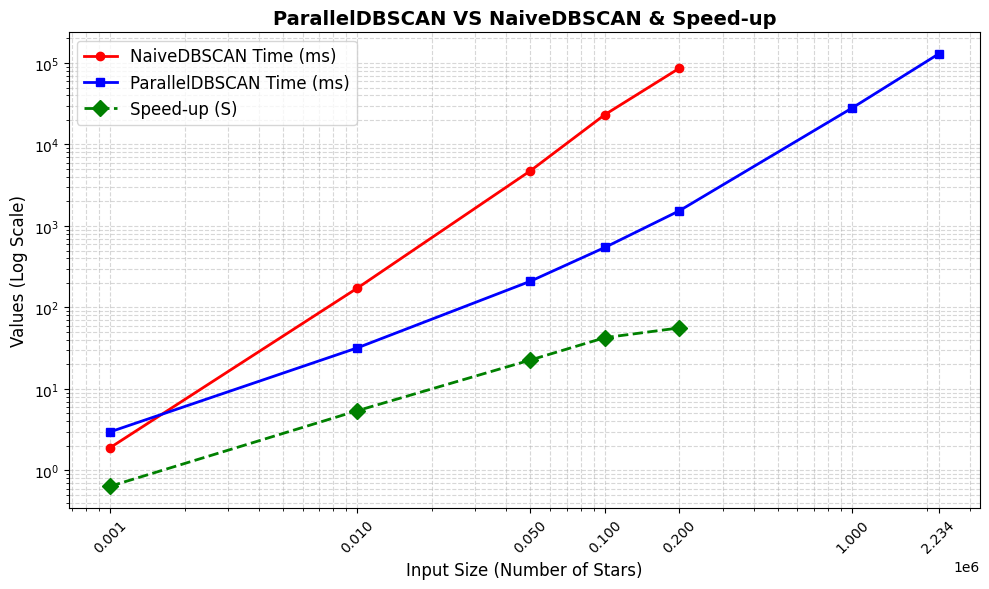

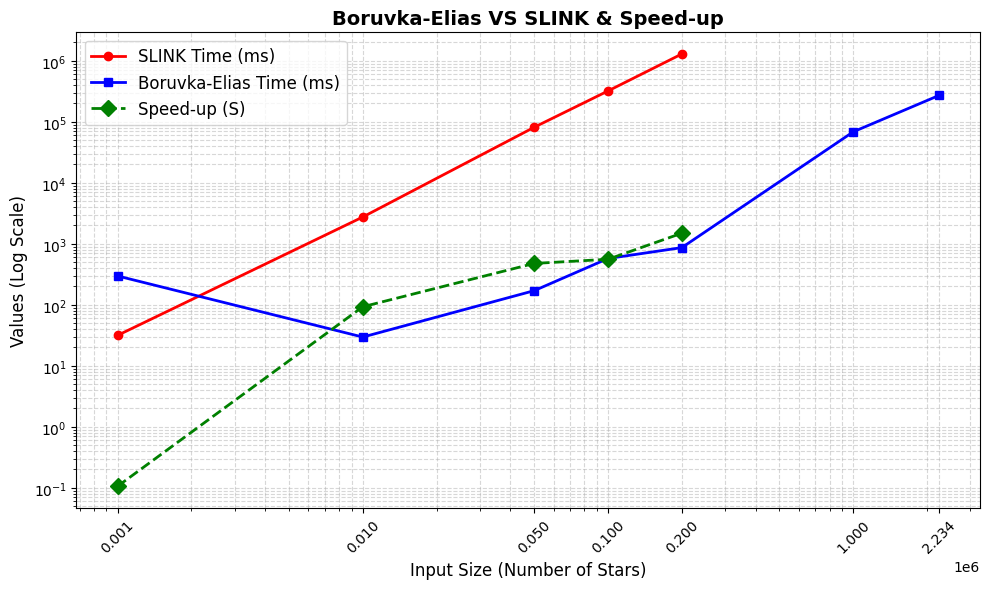

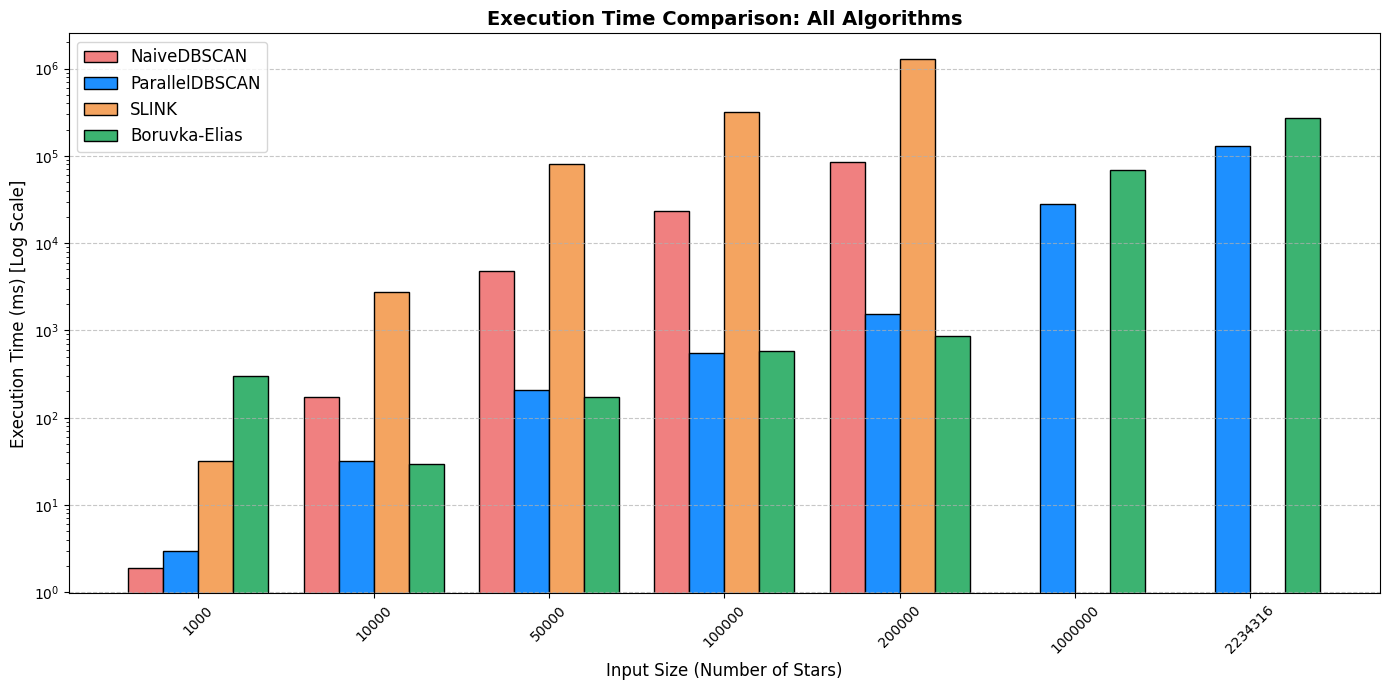

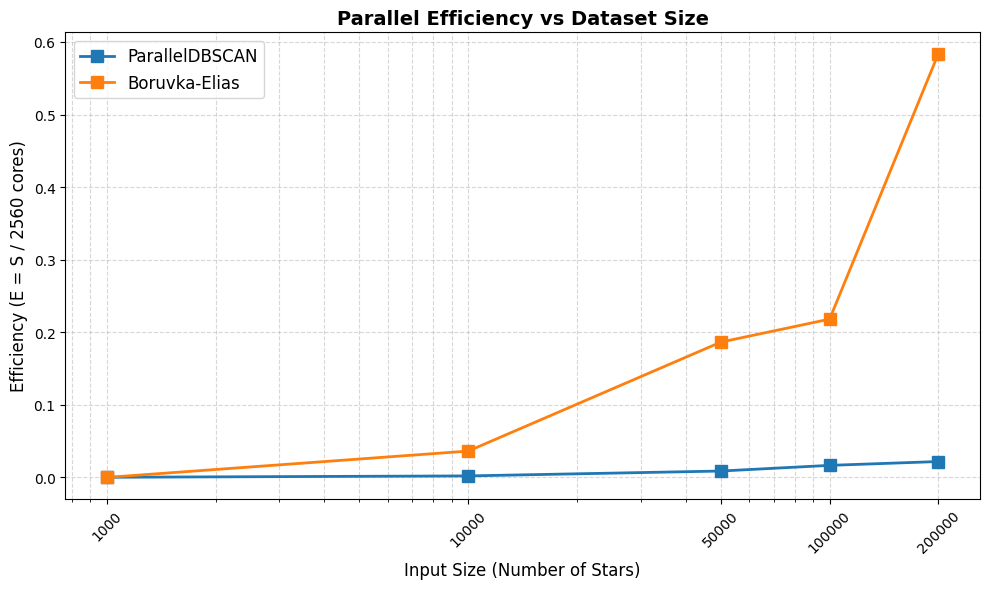

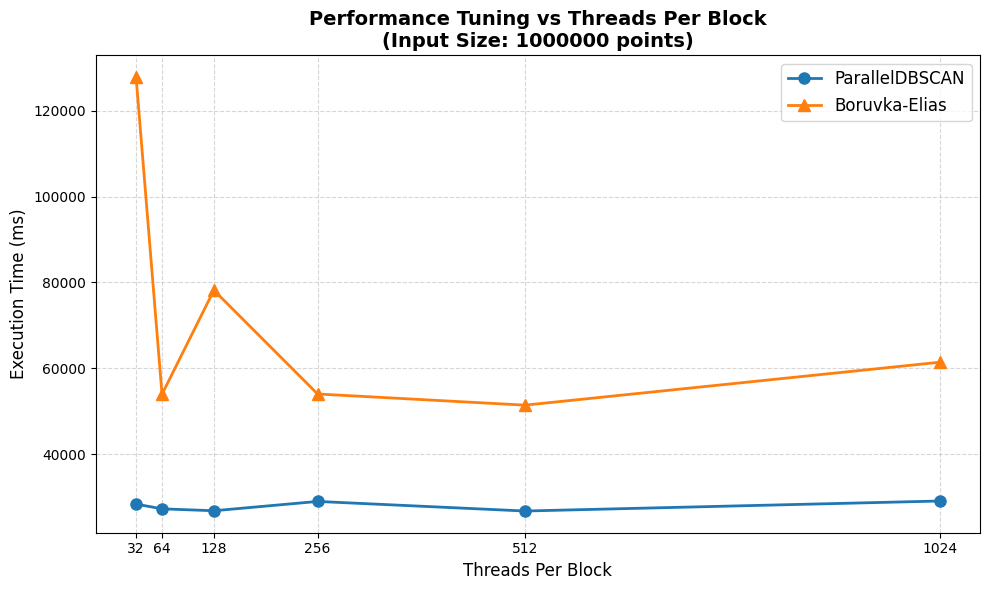

In [54]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Hardware configuration: CUDA cores for NVIDIA T4
P_CORES = 2560

# Algorithm mapping: { 'Parallel_Name': 'Sequential_Name' }
algo_mapping = {
    'parallel_dbscan': 'seq_dbscan',
    'boruvka_elias': 'slink'
}

# Custom labels for the plots
plot_labels = {
    'parallel_dbscan': ('ParallelDBSCAN', 'NaiveDBSCAN'),
    'boruvka_elias': ('Boruvka-Elias', 'SLINK')
}

expected_columns = [
    'Input_Size',
    'Num_Clusters',
    'Threads_Per_Block',
    'Blocks_Per_Grid',
    'Num_Grids',
    'Execution_Time_s',
    'Date'
]

# Reading CSV files
csv_files = glob.glob('/content/drive/MyDrive/PDPProject/OUTPUT/*.csv')
dataframes = []

for file_path in csv_files:
    filename = os.path.basename(file_path)
    if filename == 'linkage.csv':
        continue

    # The file name directly corresponds to the algorithm name
    algo_name = os.path.splitext(filename)[0]

    try:
        df = pd.read_csv(file_path, names=expected_columns, header=0)
        df['Algorithm'] = algo_name
        dataframes.append(df)
    except Exception as e:
        print(f"[ERROR] Error reading {file_path}: {e}")

if not dataframes:
    print("[WARNING] No data found. Ensure CSV files are generated and the path is correct.")
else:
    # Global DataFrame
    df_all = pd.concat(dataframes, ignore_index=True)

    # Convert execution time from seconds to milliseconds
    df_all['Execution_Time_ms'] = df_all['Execution_Time_s'] * 1000

    metrics_data = []

    for parallel_algo, seq_algo in algo_mapping.items():
        # Filter data for the algorithms in question
        df_par = df_all[df_all['Algorithm'] == parallel_algo]
        df_seq = df_all[df_all['Algorithm'] == seq_algo]

        if df_par.empty or df_seq.empty:
            print(f"[WARNING] Missing data for pair: {parallel_algo} / {seq_algo}")
            continue

        # Aggregate data by taking the mean of Execution_Time_ms for each Input_Size
        par_agg = df_par.groupby(['Algorithm', 'Input_Size'])['Execution_Time_ms'].mean().reset_index()
        seq_agg = df_seq.groupby(['Algorithm', 'Input_Size'])['Execution_Time_ms'].mean().reset_index()

        label_par, label_seq = plot_labels[parallel_algo]

        # Calculate Speed-up and Efficiency (Inner join ensures Speed-up is calculated only where both exist)
        merged = pd.merge(par_agg, seq_agg, on='Input_Size', suffixes=('_par', '_seq'))
        merged['Speed_up'] = merged['Execution_Time_ms_seq'] / merged['Execution_Time_ms_par']
        merged['Efficiency'] = merged['Speed_up'] / P_CORES
        merged['Algo_Pair'] = label_par
        metrics_data.append(merged)

        # ==========================================
        # 1. PLOT: EXECUTION TIME & SPEED-UP (SINGLE AXIS)
        # ==========================================
        plt.figure(figsize=(10, 6))

        # Plot sequential time
        plt.plot(
            seq_agg['Input_Size'], seq_agg['Execution_Time_ms'],
            marker='o', linestyle='-', color='red', linewidth=2, markersize=6, label=f'{label_seq} Time (ms)'
        )

        # Plot parallel time
        plt.plot(
            par_agg['Input_Size'], par_agg['Execution_Time_ms'],
            marker='s', linestyle='-', color='blue', linewidth=2, markersize=6, label=f'{label_par} Time (ms)'
        )

        # Plot Speed-up on the SAME axis
        plt.plot(
            merged['Input_Size'], merged['Speed_up'],
            marker='D', linestyle='--', color='green', linewidth=2, markersize=8, label='Speed-up (S)'
        )

        plt.yscale('log')
        plt.xscale('log')

        all_sizes = sorted(par_agg['Input_Size'].unique())
        ax = plt.gca()
        ax.set_xticks(all_sizes)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        plt.xticks(rotation=45)

        plt.xlabel('Input Size (Number of Stars)', fontsize=12)
        plt.ylabel('Values (Log Scale)', fontsize=12)
        plt.title(f'{label_par} VS {label_seq} & Speed-up', fontsize=14, fontweight='bold')

        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.legend(loc='upper left', fontsize=12)

        plt.tight_layout()
        plt.savefig(f'execution_and_speedup_{parallel_algo}_vs_{seq_algo}.png', dpi=300)
        plt.show()

    # ==========================================
    # 2. BAR CHART: EXECUTION TIME COMPARISON (ALL)
    # ==========================================
    plt.figure(figsize=(14, 7))
    x_labels = sorted(df_all['Input_Size'].unique())
    x = np.arange(len(x_labels))
    width = 0.2

    algos_to_plot = ['seq_dbscan', 'parallel_dbscan', 'slink', 'boruvka_elias']
    algo_display_names = ['NaiveDBSCAN', 'ParallelDBSCAN', 'SLINK', 'Boruvka-Elias']
    algo_colors = ['lightcoral', 'dodgerblue', 'sandybrown', 'mediumseagreen']

    df_agg = df_all.groupby(['Algorithm', 'Input_Size'])['Execution_Time_ms'].mean().reset_index()

    for i, algo in enumerate(algos_to_plot):
        algo_data = df_agg[df_agg['Algorithm'] == algo]
        times = []
        for size in x_labels:
            val = algo_data[algo_data['Input_Size'] == size]['Execution_Time_ms']
            times.append(val.values[0] if not val.empty else np.nan)

        offset = (i - 1.5) * width
        plt.bar(x + offset, times, width, label=algo_display_names[i],
                color=algo_colors[i], edgecolor='black', log=True)

    plt.xlabel('Input Size (Number of Stars)', fontsize=12)
    plt.ylabel('Execution Time (ms) [Log Scale]', fontsize=12)
    plt.title('Execution Time Comparison: All Algorithms', fontsize=14, fontweight='bold')
    plt.xticks(x, [str(size) for size in x_labels], rotation=45)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('execution_time_barchart_all.png', dpi=300)
    plt.show()

    # ==========================================
    # 3. PLOT: EFFICIENCY ANALYSIS
    # ==========================================
    if metrics_data:
        df_metrics = pd.concat(metrics_data, ignore_index=True)

        plt.figure(figsize=(10, 6))
        for algo_pair in df_metrics['Algo_Pair'].unique():
            data_subset = df_metrics[df_metrics['Algo_Pair'] == algo_pair]
            plt.plot(data_subset['Input_Size'], data_subset['Efficiency'],
                     marker='s', linestyle='-', linewidth=2, markersize=8, label=algo_pair)

        plt.xscale('log')
        ax = plt.gca()
        ax.set_xticks(sorted(df_metrics['Input_Size'].unique()))
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        plt.xticks(rotation=45)

        plt.xlabel('Input Size (Number of Stars)', fontsize=12)
        plt.ylabel(f'Efficiency (E = S / {P_CORES} cores)', fontsize=12)
        plt.title('Parallel Efficiency vs Dataset Size', fontsize=14, fontweight='bold')
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig('efficiency_analysis.png', dpi=300)
        plt.show()

    # ==========================================
    # 4. TUNING PLOT: THREADS PER BLOCK VS TIME
    # (Target: 1,000,000 points)
    # ==========================================
    TARGET_SIZE = 1000000
    algos_to_tune = ['parallel_dbscan', 'boruvka_elias']

    # Filter the dataset for target size and parallel algorithms
    df_tune = df_all[(df_all['Input_Size'] == TARGET_SIZE) & (df_all['Algorithm'].isin(algos_to_tune))]

    if not df_tune.empty:
        plt.figure(figsize=(10, 6))

        # Aggregate by taking the mean in case of repeated benchmark runs
        df_tune_agg = df_tune.groupby(['Algorithm', 'Threads_Per_Block'])['Execution_Time_ms'].mean().reset_index()

        markers = {'parallel_dbscan': 'o', 'boruvka_elias': '^'}

        for algo in algos_to_tune:
            algo_data = df_tune_agg[df_tune_agg['Algorithm'] == algo]

            if not algo_data.empty:
                # Sort the values by X-axis to avoid rendering broken or crossed lines
                algo_data = algo_data.sort_values(by='Threads_Per_Block')
                label_name = plot_labels.get(algo, (algo, ''))[0]

                plt.plot(
                    algo_data['Threads_Per_Block'],
                    algo_data['Execution_Time_ms'],
                    marker=markers[algo],
                    linestyle='-',
                    linewidth=2,
                    markersize=8,
                    label=label_name
                )

        plt.xlabel('Threads Per Block', fontsize=12)
        plt.ylabel('Execution Time (ms)', fontsize=12)
        plt.title(f'Performance Tuning vs Threads Per Block\n(Input Size: {TARGET_SIZE} points)', fontsize=14, fontweight='bold')

        # Force X-axis ticks to display the exact tested thread block dimensions
        tested_threads = sorted(df_tune_agg['Threads_Per_Block'].unique())
        plt.xticks(tested_threads)

        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig(f'tuning_threads_block_{TARGET_SIZE}.png', dpi=300)
        plt.show()
    else:
        print(f"\n[INFO] No data found for Input_Size = {TARGET_SIZE} with parallel algorithms.")